In [1]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud

In [39]:
import wordcloud
wordcloud.__version__

'1.8.1'

#### Load data

In [2]:
train_path = "../trainingandtestdata/training.1600000.processed.noemoticon.csv"
test_path = "../trainingandtestdata/testdata.manual.2009.06.14.csv"

In [3]:
train = pd.read_csv(train_path,encoding = "ISO-8859-1",names=['target','id','date','flag','user','text'])

#### Task 2 - Drop Data

In [4]:
## Apparently the sentiment only relevant to text
drop_col = ['id','date','flag','user']
train = train.drop(drop_col,axis=1)

#### Task 3 - Plot text length

From the distribution, Many text'length exceed 140 character. But most of them within 140.

{'whiskers': [<matplotlib.lines.Line2D at 0x292e4ea60>,
 'caps': [<matplotlib.lines.Line2D at 0x17439a100>,
 'boxes': [<matplotlib.lines.Line2D at 0x292e4e610>],
 'medians': [<matplotlib.lines.Line2D at 0x17439a820>],
 'fliers': [<matplotlib.lines.Line2D at 0x17439abb0>],
 'means': []}

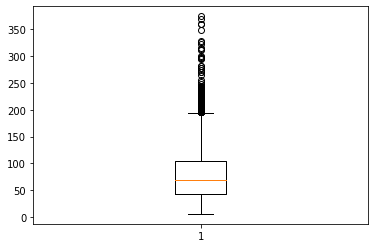

In [5]:
def get_length(text):
    return len(text)

plt.boxplot(train['text'].map(get_length))

### Task 4 - data processing (HTML)

In [6]:
print(train['text'][279])
def clean_html(text):
    return BeautifulSoup(text, 'lxml').get_text() #clean html
train['text'] = train['text'].map(clean_html)
print(train['text'][279])

Whinging. My client&amp;boss don't understand English well. Rewrote some text unreadable. It's written by v. good writer&amp;reviewed correctly. 
Whinging. My client&boss don't understand English well. Rewrote some text unreadable. It's written by v. good writer&reviewed correctly. 


#### Task 5 - Remove

In [7]:
stopwords_list = stopwords.words('english')
def remove(text):
    text = re.sub(r'@[A-Za-z0-9]+','',text) #remove menthion
    text = re.sub('https?://[A-Za-z0-9./]+','',text) #remove URL Link
    text = re.sub('www.[A-Za-z0-9./]+','',text) #remove URL Link
    text = re.sub("[^a-zA-Z]", " ", text) #remove #, punctuations mark, numbers
    
    #remove stop words
    text_tokens = word_tokenize(text)
    tokens_without_sw = [word for word in text_tokens if not word in stopwords_list]
    
    return (" ").join(tokens_without_sw)
train['text'] = train['text'].map(remove)

#### Task 6 - LowerCase

In [8]:
def to_lower(text):
    return text.lower()
train['text'] = train['text'].map(to_lower)

#### Task 7

In [9]:
## Lemmatization
lemmatizer = WordNetLemmatizer()

def lemmatize(text):
    text_tokens = word_tokenize(text)
    tokens_without_sw = [lemmatizer.lemmatize(word) for word in text_tokens]
    
    return (" ").join(tokens_without_sw)    
train['text'] = train['text'].map(lemmatize)

In [10]:
train.to_csv('../Q7_output/Q7_clean.csv')

In [32]:
## Tfidf Vectorizer
vectorizer = TfidfVectorizer(max_features=512)
X = vectorizer.fit_transform(train['text'])
print(X.shape)

(1600000, 512)


### Task 8

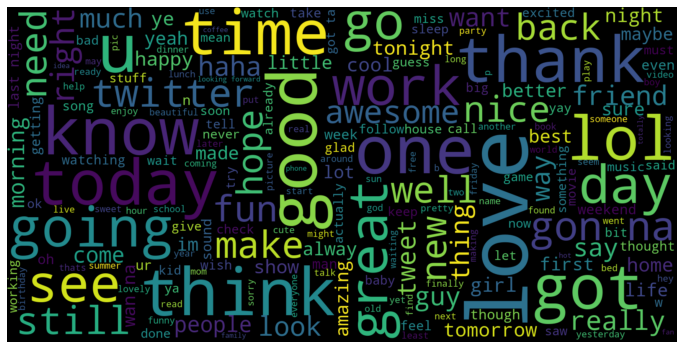

In [13]:
### Draw positive
pos = train[train['target'] == 4]
pos_str = ""
for i in pos.text:
    pos_str += i

wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(pos_str)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

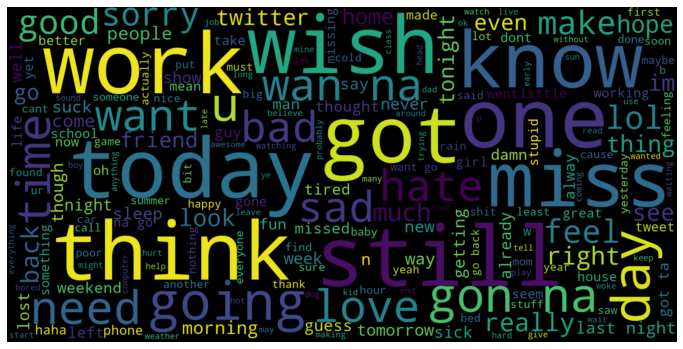

In [14]:
### Draw negative
neg = train[train['target'] == 0]
neg_str = ""
for i in neg.text:
    neg_str += i

wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(neg_str)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

#### Task9

In [15]:
pos_freq = Counter(pos_str.split())
neg_freq = Counter(neg_str.split())

words = set(pos_freq.keys()) | set(neg_freq.keys())

negative,positive = [],[]

for word in words:
    try:
        negative.append(neg_freq[word])
    except:
        negative.append(0)
    try:
        positive.append(pos_freq[word])
    except:
        positive.append(0)
    
df_freq = pd.DataFrame({"negative":negative,"positive":positive})
df_freq['total'] = df_freq['negative'] + df_freq['positive']
df_freq.index = words
df_freq = df_freq.sort_values('total',ascending=False)
df_freq.to_csv("../Q7_output/Q7_freq.csv")

#### Task10

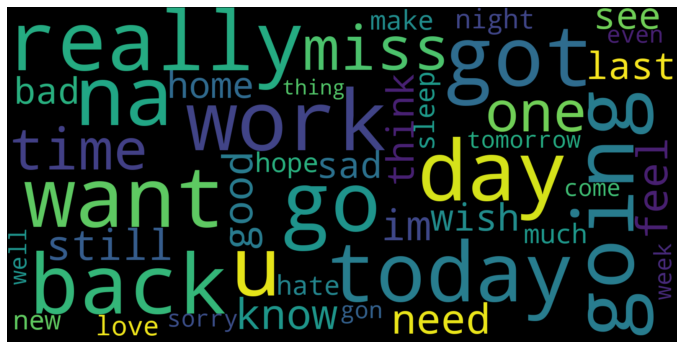

In [16]:
## Top 50 negative word
top50_neg = list(df_freq.sort_values('negative',ascending=False).index[0:50])
wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate((" ").join(top50_neg))
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

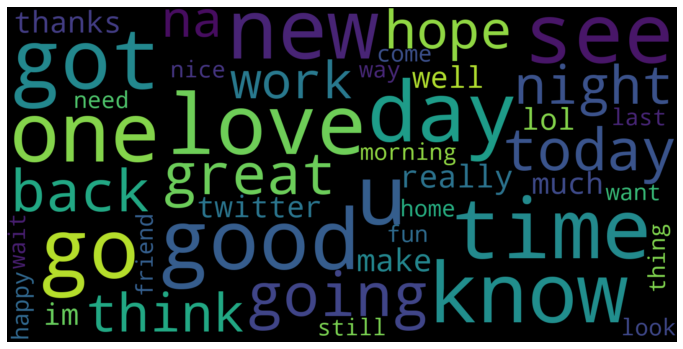

In [17]:
## Top 50 positive word
top50_pos = list(df_freq.sort_values('positive',ascending=False).index[0:50])
wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate((" ").join(top50_pos))
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

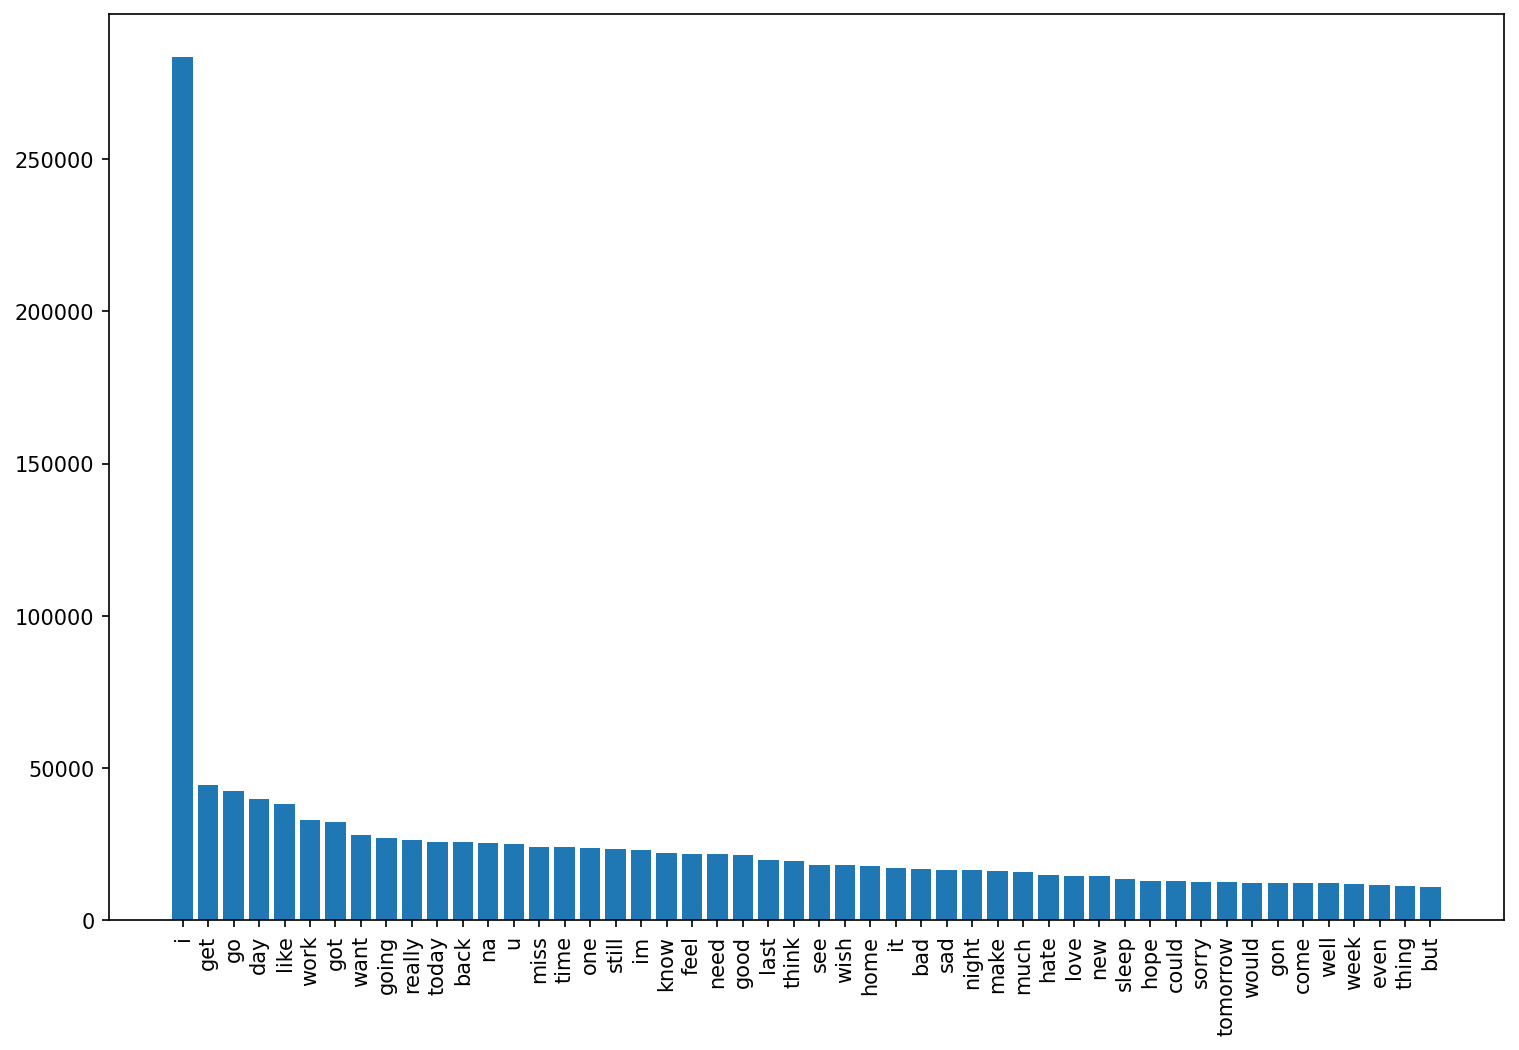

In [18]:
## Bar chart analysis
x = top50_neg
y = df_freq.sort_values('negative',ascending=False)['negative'][0:50]
plt.figure(figsize=[12,8],dpi=150)
plt.bar(x,y)
plt.xticks(rotation = 90);

#### Task 11 Model Training (See Next .ipynb)

In [34]:
#### Training Data
Train_X = X
Train_y = train['target']

In [35]:
### Testing Data
test = pd.read_csv(test_path,encoding = "ISO-8859-1",names=['target','id','date','flag','user','text'])
test= test.drop(drop_col,axis=1)
test['text'] = test['text'].map(clean_html)
test['text'] = test['text'].map(remove)
test['text'] = test['text'].map(to_lower)
test['text'] = test['text'].map(lemmatize)
Test_X = vectorizer.transform(test['text'])
Test_y = test['target']

In [36]:
Train_X.shape,Test_X.shape

((1600000, 512), (498, 512))

In [37]:
import numpy as np
with open('Train_X.npy', 'wb') as f:
    np.save(f, Train_X.toarray())

with open('Test_X.npy', 'wb') as f:
    np.save(f, Test_X.toarray())

with open('Train_y.npy', 'wb') as f:
    np.save(f, Train_y)

with open('Test_y.npy', 'wb') as f:
    np.save(f, Test_y)